In [3]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='176E-pLhoxTgWsJ3MeoJQV_GXczIA6g8D',
                                    dest_path='/content/animals.zip',
                                    unzip=True)

# Task 1  and # Task 2
loading data into train and validation data sets
and preprocessing .. changing into grayscale

In [4]:
from numpy.random import seed
seed(1)

In [5]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255.,
                                   validation_split=0.2,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2,rescale = 1./255.)

train_generator = train_datagen.flow_from_directory("animal_dataset_intermediate/train/",
                                                    batch_size = 32,
                                                    shuffle=True,
                                                    class_mode = 'categorical',
                                                    color_mode = "grayscale",
                                                    subset="training", 
                                                    target_size = (200, 200))

validation_dataset = val_datagen.flow_from_directory('animal_dataset_intermediate/train/',batch_size=32,
                                                 shuffle=True,
                                                 target_size=(200, 200), 
                                                 subset="validation",
                                                 class_mode='categorical',
                                                 color_mode="grayscale")

Found 6558 images belonging to 5 classes.
Found 1638 images belonging to 5 classes.


In [6]:
X_train,y_train = train_generator.next()


In [7]:
import numpy as np
import pandas as pd

In [8]:
X_train.shape

(32, 200, 200, 1)

In [9]:
y_train.shape

(32, 5)

In [10]:
print(X_train.ndim)
print(y_train.ndim)

4
2


In [11]:
X_train=np.array(X_train)
y_train=np.array(y_train)

In [12]:
import keras

In [13]:
class_names = ['elefante','farfalla','mucca','pecora','scoiattolo']
num_classes=5

In [14]:
y_train=y_train.argmax(axis=1)

In [15]:
y_train

array([0, 1, 1, 1, 3, 3, 4, 3, 2, 1, 0, 0, 1, 1, 4, 1, 0, 2, 2, 4, 2, 3,
       1, 2, 1, 1, 3, 2, 2, 1, 2, 1])

In [16]:
y_train.shape

(32,)

In [17]:
X_train =X_train.reshape(32,200,200)

Display image and its corresponding label

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(X_train[1])
plt.xlabel(class_names[y_train[1]])
plt.colorbar()
plt.grid(False)
plt.show()
                        

In [19]:
import random

In [ ]:
plt.figure(figsize=(15,15))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  rand_no=random.randint(0,len(X_train)-1)
  plt.imshow(X_train[rand_no])
  plt.xlabel(class_names[y_train[rand_no]])

Task 3:Building a Multi-Layer Perceptron

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Flatten,BatchNormalization
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy,categorical_crossentropy
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping
%load_ext tensorboard

import datetime



In [22]:
!rm -rf ./logs/

def create_model():
  model = Sequential()
  model.add(Flatten(input_shape=( (200, 200, 1))))
  #model.add(Dense(4096,activation='relu'))
  #model.add(Dropout(0.25))
  #model.add(Dense(2048,activation='relu'))
  #model.add(Dropout(0.5))
  model.add(Dense(1024,activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(512,activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(5,activation='softmax'))
  return model

Task 4: Optimizer

Loss function: is categorical_crossentropy because  we have five class names to classify
For e.g if we have only 2 class then we have to use binary crossentropy.
Learning Rate : As optimizer is adam its default learning rate is 0.0001

In [23]:
model = create_model()
model.summary()
#opt =RMSprop(learning_rate=0.1,decay=1e-6)
opt="Adam"
model.compile(optimizer=opt,
              #loss=SparseCategoricalCrossentropy(from_logits=True),
              loss=categorical_crossentropy,
              metrics=['accuracy'])
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystopping_callback = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 40000)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              40961024  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2565      
Total params: 41,488,389
Trainable params: 41,488,389
Non-trainable params: 0
____________________________________________

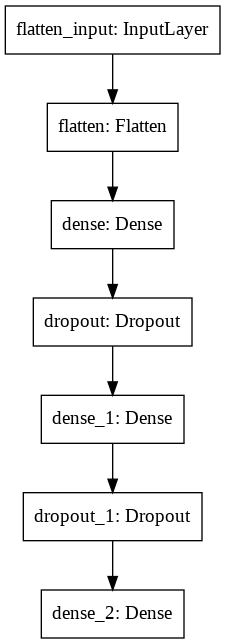

In [24]:
tf.keras.utils.plot_model(model)

In [25]:
model.fit(train_generator,
            steps_per_epoch = train_generator.samples //32,
            validation_data = validation_dataset,
            epochs = 50,
            validation_steps = validation_dataset.samples // 32,
            callbacks=[earlystopping_callback,tensorboard_callback],
          
            verbose = 2
          )


Epoch 1/50
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
204/204 - 35s - loss: 5.6040 - accuracy: 0.2021 - val_loss: 1.6054 - val_accuracy: 0.2053
Epoch 2/50
204/204 - 34s - loss: 1.6107 - accuracy: 0.2151 - val_loss: 1.5997 - val_accuracy: 0.2328
Epoch 3/50
204/204 - 34s - loss: 1.6097 - accuracy: 0.2311 - val_loss: 1.6016 - val_accuracy: 0.2322
Epoch 4/50
204/204 - 33s - loss: 1.6025 - accuracy: 0.2317 - val_loss: 1.6011 - val_accuracy: 0.2316
Epoch 5/50
204/204 - 33s - loss: 1.6031 - accuracy: 0.2320 - val_loss: 1.6022 - val_accuracy: 0.2304


for epoch 10 acc is 2289
for epoch 20 acc is 2318
for expoch 50 acc is 2320

Task 6:Tensor Board

In [26]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 216), started 1:35:31 ago. (Use '!kill 216' to kill it.)

<IPython.core.display.Javascript object>

Task 7:Building a Convolutional Neural Network

In [27]:
INPUT_SHAPE=(200,200,1)
model =tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(BatchNormalization())
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
#model.add(tf.keras.layers.Dropout(rate=0.25))


model.add(tf.keras.layers.Dense(256, activation='relu'))
#model.add(tf.keras.layers.Dropout(rate=0.25))

# model.add(tf.keras.layers.Dense(128,activation='relu'))
# model.add(tf.keras.layers.Dropout(rate=0.25))

# model.add(tf.keras.layers.Dense(64,activation='relu'))
# model.add(tf.keras.layers.Dropout(rate=0.3))

# model.add(tf.keras.layers.Dense(32,activation='relu'))
# model.add(tf.keras.layers.Dropout(rate=0.3))



# add output layer
model.add(tf.keras.layers.Dense(5, activation='softmax'))


model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# view model layers
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               18874624  
_________________________________________________________________
dense_4 (Dense)              (None, 256)              

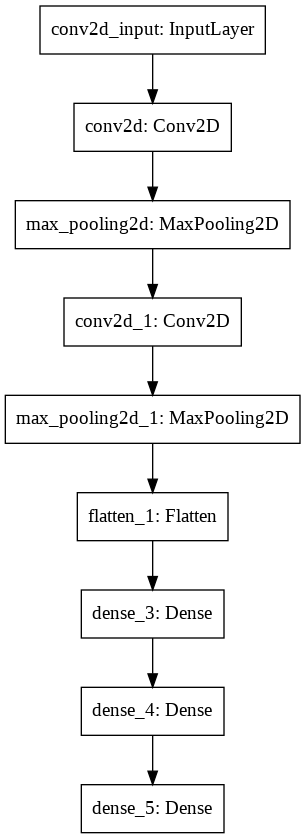

In [28]:
tf.keras.utils.plot_model(model)

In [29]:
EPOCHS = 100

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, 
                                               restore_best_weights=True,
                                               verbose=1)
# model.fit(train_generator,
#             steps_per_epoch = train_generator.samples //32,
#             validation_data = validation_dataset,
#             epochs = 50,
#             validation_steps = validation_dataset.samples // 32,
#             verbose = 2
#           )


history = model.fit(train_generator,
                    validation_data = validation_dataset,
                    batch_size=32,
                    callbacks=[es_callback], 
                    validation_steps = validation_dataset.samples // 32, 
                    epochs=EPOCHS,
                    verbose=1)


Epoch 1/100
205/205 [==============================] - 33s 159ms/step - loss: 1.6604 - accuracy: 0.3175 - val_loss: 1.3568 - val_accuracy: 0.4412
Epoch 2/100
205/205 [==============================] - 32s 158ms/step - loss: 1.3401 - accuracy: 0.4451 - val_loss: 1.2169 - val_accuracy: 0.4841
Epoch 3/100
205/205 [==============================] - 32s 158ms/step - loss: 1.2199 - accuracy: 0.4998 - val_loss: 1.1791 - val_accuracy: 0.5331
Epoch 4/100
205/205 [==============================] - 32s 156ms/step - loss: 1.1670 - accuracy: 0.5273 - val_loss: 1.0529 - val_accuracy: 0.5852
Epoch 5/100
205/205 [==============================] - 32s 158ms/step - loss: 1.1165 - accuracy: 0.5546 - val_loss: 0.9904 - val_accuracy: 0.6244
Epoch 6/100
205/205 [==============================] - 32s 158ms/step - loss: 1.0791 - accuracy: 0.5712 - val_loss: 1.0068 - val_accuracy: 0.6048
Epoch 7/100
205/205 [==============================] - 32s 156ms/step - loss: 1.0751 - accuracy: 0.5708 - val_loss: 0.9462 -

In [30]:
test_loss, test_acc = model.evaluate(validation_dataset, verbose=2)

print('\nTest accuracy:', test_acc)

52/52 - 2s - loss: 0.8535 - accuracy: 0.6764

Test accuracy: 0.6764346957206726


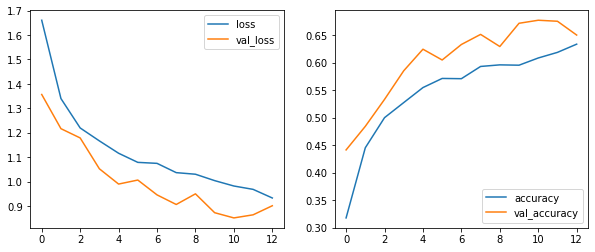

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);


Loading test data

In [32]:
import glob
import numpy as np
import pandas as pd
ord = pd.read_csv('animal_dataset_intermediate/Testing_set_animals.csv')
ordered_files = ord['filename'].to_list()
ordered_files = [f"animal_dataset_intermediate/test/{x}" for x in ordered_files]

X_test = np.array([tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(f,grayscale=True)) for f in ordered_files])

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [33]:
X_test = X_test/255.

In [34]:
import cv2
def resize_image_array(img, img_size_dims):
    img = cv2.resize(img, dsize=img_size_dims, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img
X_test = np.array([resize_image_array(img, img_size_dims=(200,200)) for img in X_test])

In [35]:
X_test = X_test.reshape(910,200,200,1)

# Task 9 Prediction:

In [36]:
predictions = model.predict(X_test)

In [37]:
prediction_labels = np.argmax(predictions,axis=1)

In [38]:
class_names = ['elefante','farfalla','mucca','pecora','scoiattolo']

In [39]:
preds = [class_names[i] for i in prediction_labels]

In [40]:
preds[89]

'pecora'

Using the pretrained model

In [41]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255.,
                                   validation_split=0.2,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2,rescale = 1./255.)

train_generator = train_datagen.flow_from_directory("animal_dataset_intermediate/train/",
                                                    batch_size = 32,
                                                    shuffle=True,
                                                    class_mode = 'categorical',
                                                    #color_mode = "grayscale",
                                                    subset="training", 
                                                    target_size = (200, 200))

validation_dataset = val_datagen.flow_from_directory('animal_dataset_intermediate/train/',batch_size=32,
                                                 shuffle=True,
                                                 target_size=(200, 200), 
                                                 subset="validation",
                                                 class_mode='categorical',
                                                 #color_mode="grayscale"
                                                 )

Found 6558 images belonging to 5 classes.
Found 1638 images belonging to 5 classes.


In [42]:
#downloading inceptionv3 model pretrained weights
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 -O inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-09-18 18:04:49--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.20.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

inception_v3_weight 100%[===================>]  83.84M   173MB/s    in 0.5s    

2020-09-18 18:04:50 (173 MB/s) - ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [43]:
weights1="inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [44]:
pre_trained_model = InceptionV3(input_shape = (200, 200,3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(weights1)

for layer in pre_trained_model.layers:
    layer.trainable = True

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [45]:
last_output = pre_trained_model.layers[-1].output

In [46]:
from tensorflow.keras.layers import Dense,Dropout,Flatten
x = Flatten()(last_output)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x) 
x = Dense(5, activation='softmax')(x)           

model = tf.keras.Model(pre_trained_model.input, x) 
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,mode='auto',restore_best_weights=True)
model.compile(optimizer = tf.keras.optimizers.Adam(lr=2e-5), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [47]:
history = model.fit(
            train_generator,
            steps_per_epoch = train_generator.samples //32,
            validation_data = validation_dataset,
            epochs = 10,
            callbacks = [es],
            validation_steps = validation_dataset.samples // 32,
            verbose = 2)

Epoch 1/10
204/204 - 80s - loss: 0.5521 - accuracy: 0.7977 - val_loss: 0.1704 - val_accuracy: 0.9412
Epoch 2/10
204/204 - 78s - loss: 0.3100 - accuracy: 0.8935 - val_loss: 0.1554 - val_accuracy: 0.9467
Epoch 3/10
204/204 - 78s - loss: 0.2373 - accuracy: 0.9128 - val_loss: 0.1295 - val_accuracy: 0.9528
Epoch 4/10
204/204 - 78s - loss: 0.2095 - accuracy: 0.9260 - val_loss: 0.1358 - val_accuracy: 0.9571
Epoch 5/10
204/204 - 78s - loss: 0.1657 - accuracy: 0.9410 - val_loss: 0.1236 - val_accuracy: 0.9583
Epoch 6/10
204/204 - 77s - loss: 0.1630 - accuracy: 0.9415 - val_loss: 0.1142 - val_accuracy: 0.9614
Epoch 7/10
204/204 - 77s - loss: 0.1342 - accuracy: 0.9557 - val_loss: 0.1212 - val_accuracy: 0.9645
Epoch 8/10
204/204 - 77s - loss: 0.1228 - accuracy: 0.9559 - val_loss: 0.1229 - val_accuracy: 0.9632
Epoch 9/10
204/204 - 78s - loss: 0.1110 - accuracy: 0.9606 - val_loss: 0.0980 - val_accuracy: 0.9663
Epoch 10/10
204/204 - 77s - loss: 0.0940 - accuracy: 0.9687 - val_loss: 0.1028 - val_accura

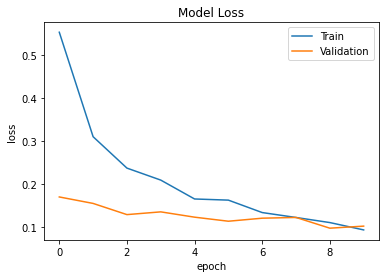

In [48]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')

plt.xlabel('epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [49]:
model.save('content/saved_model/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: content/saved_model/assets


loading the test data

In [50]:
import tensorflow as tf
model = tf.keras.models.load_model('content/saved_model/')

In [51]:
test_loss, test_acc = model.evaluate(validation_dataset, verbose=2)

print('\nTest accuracy:', test_acc)

52/52 - 4s - loss: 0.1024 - accuracy: 0.9695

Test accuracy: 0.9694749712944031


In [65]:
import glob
import numpy as np
import pandas as pd
ord = pd.read_csv('animal_dataset_intermediate/Testing_set_animals.csv')
ordered_files = ord['filename'].to_list()
ordered_files = [f"animal_dataset_intermediate/test/{x}" for x in ordered_files]

X_test = np.array([tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(f)) for f in ordered_files])

In [66]:
X_test = X_test/255.

In [67]:
import cv2
def resize_image_array(img, img_size_dims):
    img = cv2.resize(img, dsize=img_size_dims, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img
X_test = np.array([resize_image_array(img, img_size_dims=(200,200)) for img in X_test])

In [55]:
X_test.shape 

(910, 200, 200, 3)

In [56]:
X_test = np.array(X_test, dtype=np.uint8)

#Task 9: Predict

In [68]:
predictions = model.predict(X_test)

In [69]:
prediction_labels = np.argmax(predictions,axis=1)

In [70]:
prediction_labels

array([1, 1, 1, 1, 1, 1, 0, 3, 3, 3, 3, 0, 0, 0, 3, 1, 0, 0, 3, 1, 3, 0,
       3, 3, 3, 3, 0, 1, 1, 1, 3, 3, 3, 3, 3, 0, 0, 3, 3, 1, 1, 3, 1, 3,
       3, 0, 0, 0, 0, 0, 0, 1, 1, 1, 3, 1, 3, 0, 1, 3, 3, 1, 1, 1, 3, 1,
       3, 1, 1, 3, 0, 1, 3, 3, 3, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 3, 0,
       0, 0, 1, 3, 0, 0, 0, 3, 1, 0, 3, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 3, 0, 3, 3, 0, 0, 3, 0, 1, 3, 0, 0, 3, 0, 3, 0, 1, 4, 3,
       0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 1, 1, 0, 0, 0, 3, 1, 1,
       0, 3, 3, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 3, 1, 0, 1,
       3, 1, 1, 3, 1, 3, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 3, 0, 3,
       3, 3, 0, 0, 3, 0, 3, 0, 1, 1, 1, 0, 1, 1, 1, 3, 1, 1, 1, 1, 1, 0,
       3, 0, 1, 3, 1, 1, 0, 0, 3, 3, 0, 0, 0, 3, 0, 1, 1, 3, 0, 1, 1, 1,
       0, 0, 3, 3, 1, 1, 1, 1, 1, 1, 0, 1, 0, 3, 1, 1, 2, 1, 3, 0, 3, 3,
       3, 3, 1, 1, 0, 1, 1, 1, 3, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 3,
       3, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 0,

In [71]:
class_names = ['elefante','farfalla','mucca','pecora','scoiattolo']

In [72]:
preds = [class_names[i] for i in prediction_labels]

Plotting the test data and its predicted labels

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_test[89])
plt.xlabel(preds[89])

In [ ]:
plt.figure(figsize=(15,15))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  rand_no=random.randint(0,len(X_test))
  plt.imshow(X_test[rand_no])
  plt.xlabel([preds[rand_no]])

In [ ]:
res = pd.DataFrame({'filename': ord['filename'], 'animal_type': preds})  # prediction is nothing but the final predictions of your model on input features of your new unseen test data
res.to_csv("submission.csv") 

# To download the csv file locally
from google.colab import files        
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>